# DAOFind, Peak Finding and Statistics Computation

Study ways to improve DAOFind, common values for statistics and peak finding. Comparing ASTROPOP implementation with Stetson (python port by D. Jones in [PythonPhot](https://github.com/djones1040/PythonPhot/)) and Astropy affiliated [Photutils](https://github.com/astropy/photutils).

In [1]:
import sys
sys.path.append('.')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
from scipy.ndimage.filters import convolve

from library.gen_image import gen_image
from library.stetson_daofind import stetson_image_params, stetson_kernels, stetson_find_peaks, \
                                   stetson_sharpness, stetson_source_chunk

from skimage.feature import peak_local_max

from photutils.detection import find_peaks
from photutils.datasets import load_star_image

from astropy.stats import gaussian_fwhm_to_sigma

## Peak Finding

We will compare 3 algorithms here:
- Stetson DAOFind, that seeks local maximuns inside a box
- Photutils `peak_find`, used in Photutils source detection
- Scikit-image `peak_local_max`, that uses local max filter

All these algorithms will be applyed in the gausian-kernel convolved image.

### Using simulated stars

For the first peak fingind test, lets use a image with some strange sources. 3 round, 3 very alonged and 3 sharp cosmicray-like.

<IPython.core.display.Javascript object>


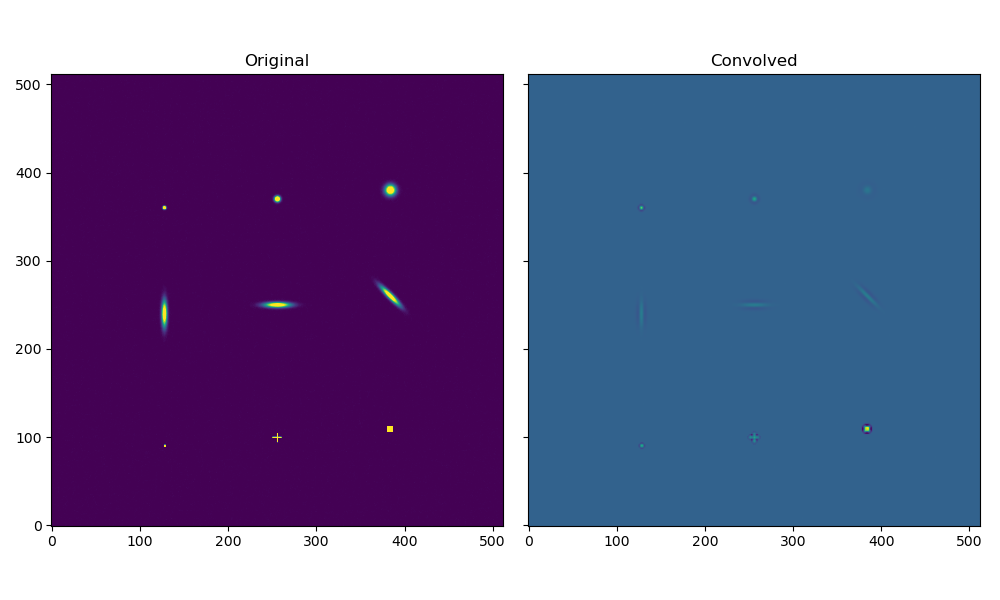

In [2]:
# Image: # 3x3 "stars"
# first row just scraps, second row elipses, third row different fwhm
size = (512, 512)
posx = [128, 256, 384]*3
posy = np.ravel([np.arange(90, 120, step=10),
                 np.arange(240, 270, step=10),
                 np.arange(360, 390, step=10)])
flux = (0, 0, 0, 80000, 80000, 80000, 50000, 60000, 80000)
sigma_x = (1, 1, 1, 2, 10, 2, 1, 2, 4)
sigma_y = (1, 1, 1, 10, 2, 10, 1, 2, 4)
fwhm = 5
theta = (0, 0, 0, 0, 0, 45, 0, 0, 0)
sky = 800
rdnoise = 20  # very low noise
min_snr = 10

im = gen_image(size, posx, posy, flux, sky, rdnoise,
               model='gaussian', sigma=(sigma_x, sigma_y),
               theta=theta)

# crap sources
im[posy[0]:posy[0]+2, posx[0]:posx[0]+2] = 15000
im[posy[1]-5:posy[1]+5, posx[1]] = 15000
im[posy[1], posx[1]-5:posx[1]+5] = 15000
im[posy[2]-3:posy[2]+3, posx[2]-3:posx[2]+3] += 25000
im[posy[2], posx[2]] += 25000

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
ax[0].imshow(im, origin='lower', vmin=800, vmax=6000)
ax[0].set_title('Original')

image, hmin, n_x, n_y, radius, nhalf, nbox, _, sigsq = stetson_image_params(fwhm, min_snr, rdnoise, im, sky)
mask, g, pixels, c, c1 = stetson_kernels(radius, nhalf, nbox, sigsq)
h = convolve(image, c)
ax[1].imshow(h, origin='lower')
ax[1].set_title('Convolved')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


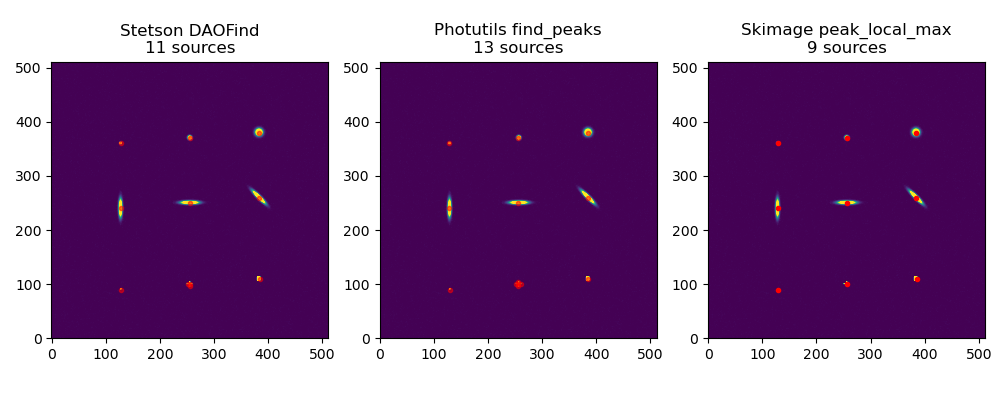

stetson
1.32 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
photutils
5.88 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
skimage
7.23 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

# Stetson daofind
print('stetson')
%timeit -n1 stetson_find_peaks(h, hmin, mask, pixels, nhalf, n_x, n_y)
ix, iy, ngood = stetson_find_peaks(h, hmin, mask, pixels, nhalf, n_x, n_y)
ax[0].imshow(im, origin='lower', vmin=800, vmax=3200)
ax[0].plot(ix, iy, 'r.', alpha=0.5)
ax[0].set_title(f'Stetson DAOFind\n{len(ix)} sources')

# Using photutils default
print('photutils')
%timeit -n1 find_peaks(h, hmin)
peaks = find_peaks(h, hmin)
ax[1].imshow(im, origin='lower', vmin=800, vmax=3200)
ax[1].plot(peaks['x_peak'], peaks['y_peak'], 'r.', alpha=0.5)
ax[1].set_title(f'Photutils find_peaks\n{len(peaks)} sources')

# using scikit-image
print('skimage')
%timeit -n1 peak_local_max(h, min_distance=int(fwhm), threshold_rel=hmin/np.max(h))
peaks = peak_local_max(h, min_distance=int(fwhm), threshold_rel=hmin/np.max(h))
ax[2].imshow(im, origin='lower', vmin=800, vmax=3200)
ax[2].plot(peaks[:, 1], peaks[:, 0], 'r.')
ax[2].set_title(f'Skimage peak_local_max\n{len(peaks)} sources')

plt.tight_layout()
plt.show()

### Conclusions on simulated image:
- Both Stetson and Photutils found spurious peaks, specially in the hard edge sources. Photutils found more of them.
- Scikit-image needed some tunning in the min_distance and threshold_rel parameters but these combinations seems to work well:
  - `threshold_rel=hmin/np.max(h)`
  - `min_distance=int(fwhm)`

### Real image

Lets try a real image from Photutils dataset. Again, applying the peak finding in the convolved image. This image has saturated stars, that appear with dark center on convolved image.

<IPython.core.display.Javascript object>


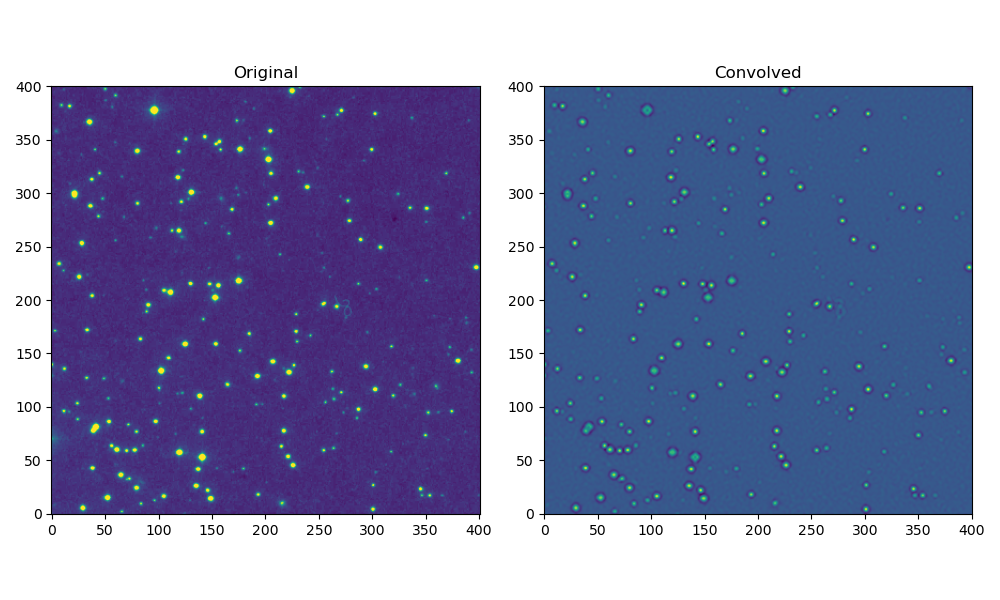

In [4]:
hdu = load_star_image()
im = hdu.data[600:1001, 600:1001].astype('f8')
fwhm = 5
bkg = np.median(im)
rms = np.std(im)
snr = 10

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(im, origin='lower', vmax=12000)
ax[0].set_title('Original')

image, hmin, n_x, n_y, radius, nhalf, nbox, _, sigsq = stetson_image_params(fwhm, min_snr, rms, im, bkg)
mask, g, pixels, c, c1 = stetson_kernels(radius, nhalf, nbox, sigsq)
h = convolve(image, c)
ax[1].imshow(h, origin='lower')
ax[1].set_title('Convolved')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


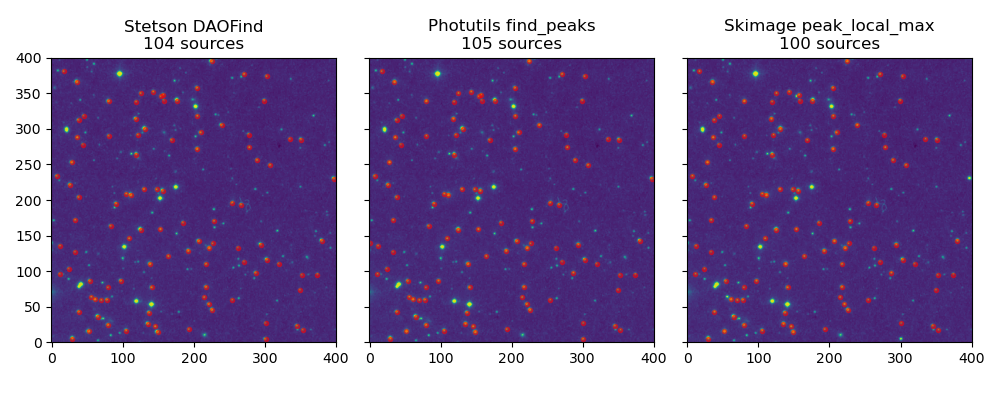

stetson
1.33 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
photutils
3.24 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
skimage
5.68 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

# Stetson daofind
from library.stetson_daofind import stetson_find_peaks
print('stetson')
%timeit -n1 stetson_find_peaks(h, hmin, mask, pixels, nhalf, n_x, n_y)
ix, iy, ngood = stetson_find_peaks(h, hmin, mask, pixels, nhalf, n_x, n_y)
ax[0].imshow(im, origin='lower')
ax[0].plot(ix, iy, 'r.', alpha=0.5)
ax[0].set_title(f'Stetson DAOFind\n{len(ix)} sources')

# Using photutils default
from photutils.detection import find_peaks
print('photutils')
%timeit -n1 find_peaks(h, hmin)
peaks = find_peaks(h, hmin)
ax[1].imshow(im, origin='lower')
ax[1].plot(peaks['x_peak'], peaks['y_peak'], 'r.', alpha=0.5)
ax[1].set_title(f'Photutils find_peaks\n{len(peaks)} sources')

# using scikit-image
from skimage.feature import peak_local_max
print('skimage')
%timeit -n1 peak_local_max(h, min_distance=int(fwhm), threshold_rel=hmin/np.max(h))
peaks = peak_local_max(h, min_distance=int(fwhm), threshold_rel=hmin/np.max(h))
ax[2].imshow(im, origin='lower')
ax[2].plot(peaks[:, 1], peaks[:, 0], 'r.', alpha=0.5)
ax[2].set_title(f'Skimage peak_local_max\n{len(peaks)} sources')

plt.tight_layout()
plt.show()

### Conclusions on real image

Here, the results are almost identical, but skimage lost some weak sources near brighter peaks. Adjusting the `min_distance` to `fwhm/1.5` this problem is solved. However, using this value in the simulated image make skimage find exactly the same sources as Stetson algorith.

All the algorithms ignored saturated stars, due to the valleys in the center of the convolved image.

## Sharpness

How sharpness in DAOFind works? What are the typical values?

### Influence of FWHM/Sigma

Lets create a image with gaussian sources with different FWHM.

The results of the code bellow shows:
- Typical values of optimal sharpness seems to be from 0.40 to 0.50.
- As the sgima of the source extends, its sharpness decreases. But, even in the most extended cases, where the peak finding would not find the source, the sharpness never got lower than 0.30.
    - For very extended sources, it seems that the behavior of the sharpness goes crazy.
- As the sigma becomes smaller than the optimal, the sharpness inceases fast.

<IPython.core.display.Javascript object>


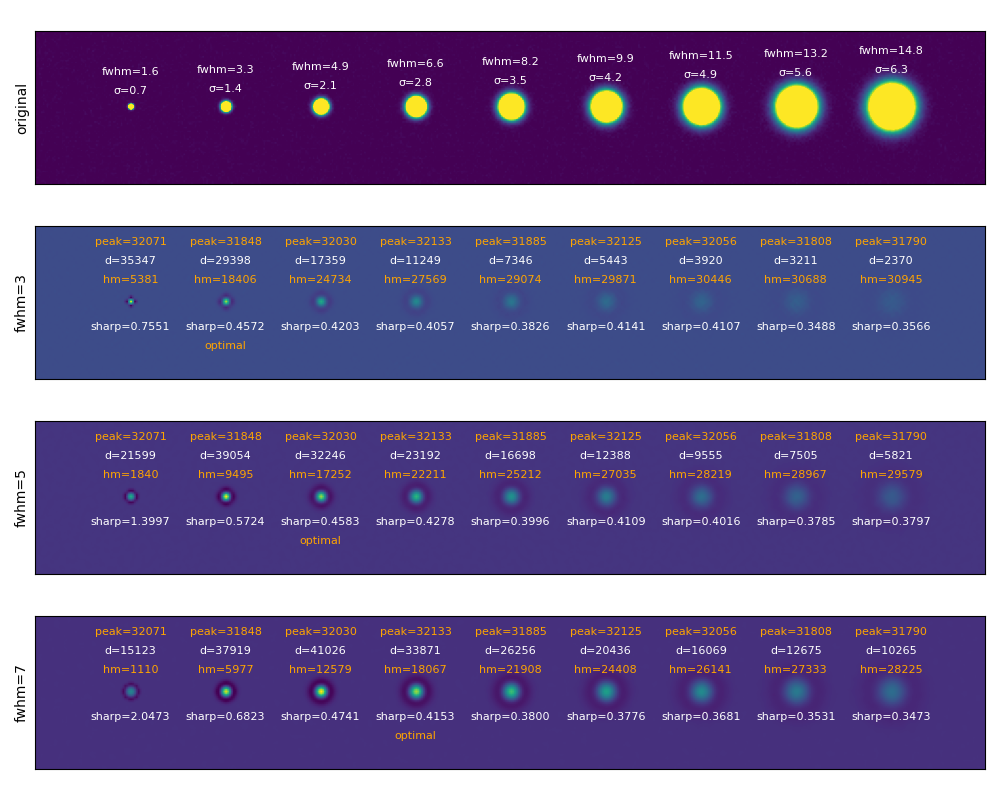

In [6]:
image_size = (80, 500)
xpos = np.arange(1, 10, 1)*50
ypos = np.ones_like(xpos)*40
sigma = np.arange(1, 10, 1)*0.7
flux = (np.ones_like(xpos)*sigma)*80000
sky = 800
rdnoise = 50
min_snr = 50

im = gen_image(image_size, xpos, ypos, flux, sky, rdnoise,
               model='gaussian', sigma=sigma)

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].imshow(im, origin='lower', vmin=800, vmax=6000)
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_ylabel('original')
for j in range(len(xpos)):
    ax[0].annotate(f'σ={sigma[j]:.1f}', (xpos[j], ypos[j]+5+2*sigma[j]), ha='center', fontsize=8, color='white')
    ax[0].annotate(f'fwhm={sigma[j]*2.355:.1f}', (xpos[j], ypos[j]+15+2*sigma[j]), ha='center', fontsize=8, color='white')

for i, fwhm in enumerate([3, 5, 7]):
    axi = ax[i+1]
    image, hmin, n_x, n_y, radius, nhalf, nbox, _, sigsq = stetson_image_params(fwhm, min_snr, rdnoise, im, sky)
    mask, g, pixels, c, c1 = stetson_kernels(radius, nhalf, nbox, sigsq)
    h = convolve(image, c)
    axi.imshow(h, origin='lower')
    axi.set_xticks([], [])
    axi.set_yticks([], [])
    axi.set_ylabel(f'fwhm={fwhm}')
    
    # source parameters
    mask[nhalf, nhalf] = 0
    for j in range(len(xpos)):
        d = h[ypos[j], xpos[j]]  # center convolved pixel intensity
        axi.annotate(f"d={d:.0f}", (xpos[j], ypos[j]+20), ha='center', fontsize=8, color='white')
        chunk = stetson_source_chunk(image, xpos[j], ypos[j], nhalf)
        peak = chunk[nhalf, nhalf]  # real peak intensity
        axi.annotate(f"peak={peak:.0f}", (xpos[j], ypos[j]+30), ha='center', fontsize=8, color='orange')
        hm = np.sum(mask*chunk)/np.sum(mask)  # median value of pixels around the center
        axi.annotate(f"hm={hm:.0f}", (xpos[j], ypos[j]+10), ha='center', fontsize=8, color='orange')
        sharp = stetson_sharpness(chunk, nhalf, mask, d)
        axi.annotate(f"sharp={sharp:.4f}", (xpos[j], ypos[j]-15), ha='center', fontsize=8, color='white')
        if np.abs(sigma[j]*2.355-fwhm) < 1:
            axi.annotate(f"optimal", (xpos[j], ypos[j]-25), ha='center', fontsize=8, color='orange')

plt.tight_layout()
plt.show()

### Influence of the source brightness

Lets test a set of stars, with the same sigma, but different fluxes. It's very clear that, except for the noise, the source intensity do not play any important role on the sharpness.

<IPython.core.display.Javascript object>


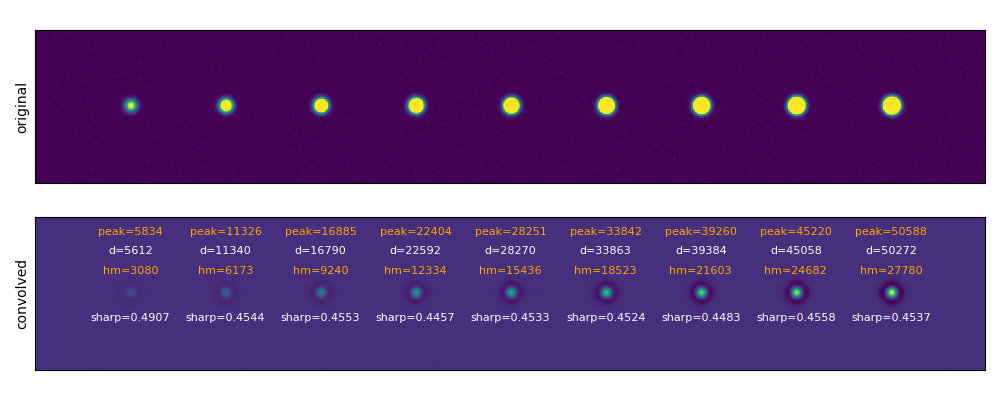

In [7]:
image_size = (80, 500)
xpos = np.arange(1, 10, 1)*50
ypos = np.ones_like(xpos)*40
fwhm = 5
sigma = 5*gaussian_fwhm_to_sigma
flux = np.arange(1, len(xpos)+1)*30000
sky = 800
rdnoise = 50
min_snr = 50

im = gen_image(image_size, xpos, ypos, flux, sky, rdnoise,
               model='gaussian', sigma=sigma)
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(im, origin='lower', vmin=800, vmax=6000)
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_ylabel('original')

axi = ax[1]
image, hmin, n_x, n_y, radius, nhalf, nbox, _, sigsq = stetson_image_params(fwhm, min_snr, rdnoise, im, sky)
mask, g, pixels, c, c1 = stetson_kernels(radius, nhalf, nbox, sigsq)
h = convolve(image, c)
axi.imshow(h, origin='lower')
axi.set_xticks([], [])
axi.set_yticks([], [])
axi.set_ylabel(f'convolved')

# source parameters
mask[nhalf, nhalf] = 0
for j in range(len(xpos)):
    d = h[ypos[j], xpos[j]]  # center convolved pixel intensity
    axi.annotate(f"d={d:.0f}", (xpos[j], ypos[j]+20), ha='center', fontsize=8, color='white')
    chunk = stetson_source_chunk(image, xpos[j], ypos[j], nhalf)
    peak = chunk[nhalf, nhalf]  # real peak intensity
    axi.annotate(f"peak={peak:.0f}", (xpos[j], ypos[j]+30), ha='center', fontsize=8, color='orange')
    hm = np.sum(mask*chunk)/np.sum(mask)  # median value of pixels around the center
    axi.annotate(f"hm={hm:.0f}", (xpos[j], ypos[j]+10), ha='center', fontsize=8, color='orange')
    sharp = stetson_sharpness(chunk, nhalf, mask, d)
    axi.annotate(f"sharp={sharp:.4f}", (xpos[j], ypos[j]-15), ha='center', fontsize=8, color='white')

plt.tight_layout()
plt.show()

### Extreme cases

How the sharpness behave in extreme cases:
- No source at all;
- Just one very high pixel above plain sky;
- Just one pixel bellow the sky;
- A box of pixels above plain sky;
- Pure noise;

As results we see that:
- Even for 1-pixel sources, the intensity do not matter.
  - Negative intensity give the same sharpness.
- Boxes with sharp edges in the same size of fwhm give sharpness 0.2.
- Noise is just random, with possible extreme values, due to the random value of d. So, it is "probably" safe against noise being detected as source.
- Plain gives 0 division error. So return `nan` sharpness.

<IPython.core.display.Javascript object>


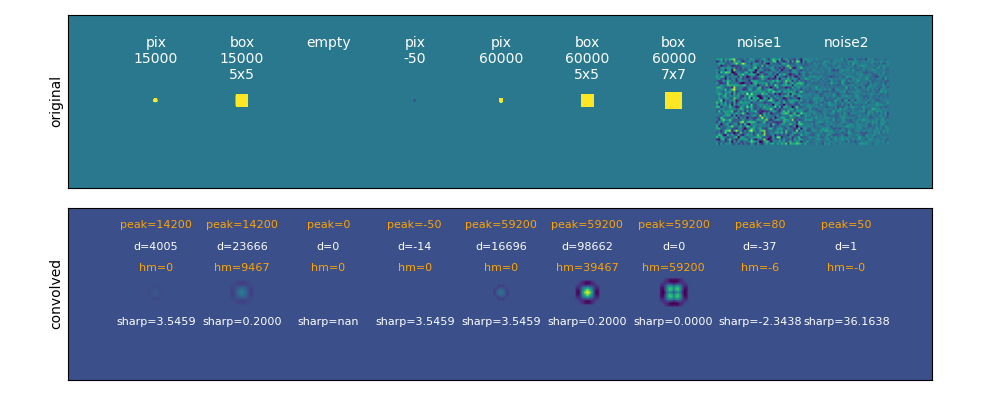

In [8]:
sky = 800
im = np.ones((80, 400))*sky

im[40, 40] = 15000
im[40, 200] = 60000
im[38:43,  78:83] = 15000
im[40,  160] = 750
im[38:43,  238:243] = 60000
im[37:44,  277:284] = 60000
im[20:-20, 300:340] += np.random.normal(loc=0, scale=50, size=(40, 40))
im[40, 320] = 880  # but the central pixel is a bit above
im[20:-20, 340:380] += np.random.normal(loc=0, scale=20, size=(40, 40))
im[40, 360] = 850 # but the central pixel is a bit above
fwhm = 5

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(im, origin='lower', vmin=700, vmax=950)
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_ylabel('original')
for x, t in zip([40, 80, 120, 160, 200, 240, 280, 320, 360],
                ['pix\n15000', 'box\n15000\n5x5', 'empty', 'pix\n-50',
                 'pix\n60000', 'box\n60000\n5x5', 'box\n60000\n7x7',
                 'noise1', 'noise2']):
    ax[0].annotate(t, (x, 70), color='white', ha='center', va='top')

axi = ax[1]
image, hmin, n_x, n_y, radius, nhalf, nbox, _, sigsq = stetson_image_params(fwhm, 0, 0, im, sky)
mask, g, pixels, c, c1 = stetson_kernels(radius, nhalf, nbox, sigsq)
h = convolve(image, c)
axi.imshow(h, origin='lower')
axi.set_xticks([], [])
axi.set_yticks([], [])
axi.set_ylabel(f'convolved')

# source parameters
mask[nhalf, nhalf] = 0
for j in range(1, 10, 1):
    x = j*40
    y = 40
    d = h[y, x]  # center convolved pixel intensity
    axi.annotate(f"d={d:.0f}", (x, y+20), ha='center', fontsize=8, color='white')
    chunk = stetson_source_chunk(image, x, y, nhalf)
    peak = chunk[nhalf, nhalf]  # real peak intensity
    axi.annotate(f"peak={peak:.0f}", (x, y+30), ha='center', fontsize=8, color='orange')
    hm = np.sum(mask*chunk)/np.sum(mask)  # median value of pixels around the center
    axi.annotate(f"hm={hm:.0f}", (x, y+10), ha='center', fontsize=8, color='orange')
    sharp = stetson_sharpness(chunk, nhalf, mask, d)
    axi.annotate(f"sharp={sharp:.4f}", (x, y-15), ha='center', fontsize=8, color='white')

plt.tight_layout()
plt.show()